Upload the original/reference WAV file:


Saving 10sec.wav to 10sec.wav
Upload the processed/compressed WAV file:


Saving output.wav to output.wav
Original: duration=11.944s, RMS=0.041075, peak=0.480362, SR=44100 Hz
Processed: duration=11.944s, RMS=0.041220, peak=0.476562, SR=44100 Hz


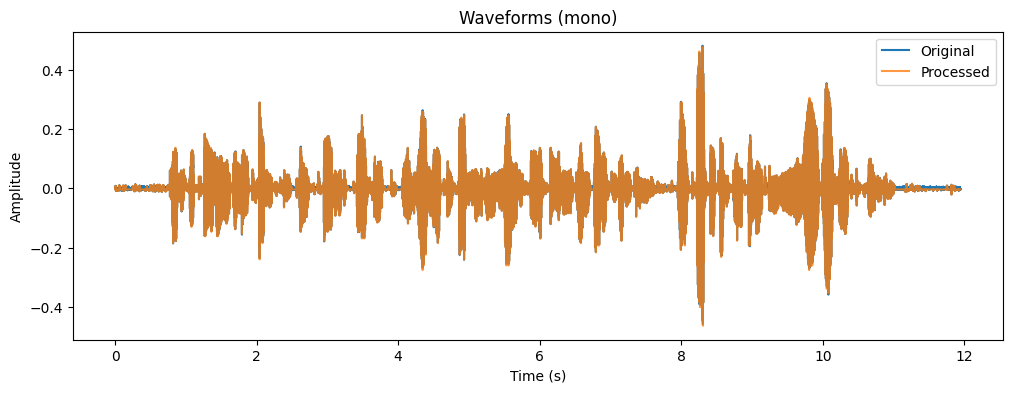

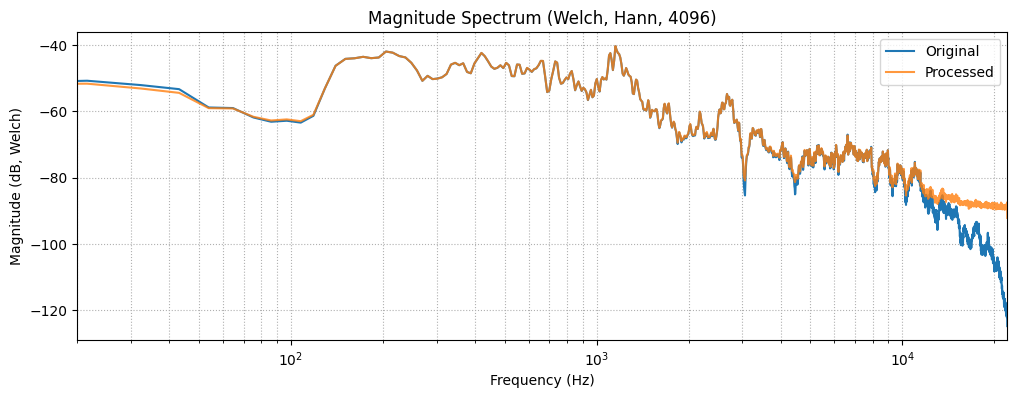

/tmp/ipython-input-617221790.py:98: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


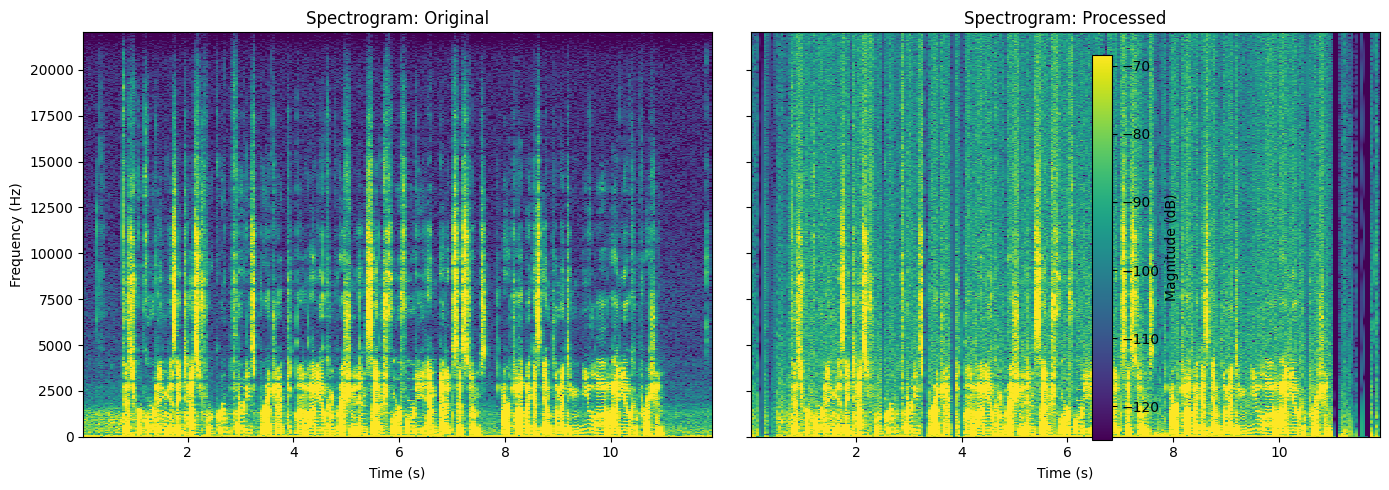

In [1]:
# Quality Analysis program to evaluate the relative perceptual quality of speech audio files


# Install dependencies
!pip install numpy scipy matplotlib soundfile --quiet

import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import welch, get_window, spectrogram
from google.colab import files

# --- Upload uncompressed file ---
print("Upload the original/reference WAV file:")
uploaded1 = files.upload()
wav1_path = list(uploaded1.keys())[0]


# --- Upload decompressed file ---
print("Upload the processed/compressed WAV file:")
uploaded2 = files.upload()
wav2_path = list(uploaded2.keys())[0]

# --- Utility functions ---
def load_mono(path):
    data, sr = sf.read(path, always_2d=True)
    mono = data.mean(axis=1).astype(np.float64, copy=False)
    return mono, sr

def stats(x):
    rms = np.sqrt(np.mean(x**2)) if x.size else 0.0
    peak = np.max(np.abs(x)) if x.size else 0.0
    return rms, peak

# --- Load ---
x1, sr1 = load_mono(wav1_path)
x2, sr2 = load_mono(wav2_path)

# --- Time vectors ---
t1 = np.arange(len(x1))/sr1
t2 = np.arange(len(x2))/sr2

# --- Welch magnitude spectra ---
win = get_window("hann", 4096)
nperseg = len(win)
noverlap = nperseg // 2

f1, Pxx1 = welch(x1, fs=sr1, window=win, nperseg=nperseg, noverlap=noverlap, scaling="spectrum")
f2, Pxx2 = welch(x2, fs=sr2, window=win, nperseg=nperseg, noverlap=noverlap, scaling="spectrum")
mag1_db = 10*np.log10(np.maximum(Pxx1, 1e-20))
mag2_db = 10*np.log10(np.maximum(Pxx2, 1e-20))

# --- Spectrograms ---
fS1, tS1, Sxx1 = spectrogram(x1, fs=sr1, window=win, nperseg=nperseg, noverlap=noverlap, scaling="spectrum", mode="magnitude")
fS2, tS2, Sxx2 = spectrogram(x2, fs=sr2, window=win, nperseg=nperseg, noverlap=noverlap, scaling="spectrum", mode="magnitude")
Sxx1_db = 20*np.log10(np.maximum(Sxx1, 1e-10))
Sxx2_db = 20*np.log10(np.maximum(Sxx2, 1e-10))

# --- Stats ---
rms1, peak1 = stats(x1)
rms2, peak2 = stats(x2)
print(f"Original: duration={len(x1)/sr1:.3f}s, RMS={rms1:.6f}, peak={peak1:.6f}, SR={sr1} Hz")
print(f"Processed: duration={len(x2)/sr2:.3f}s, RMS={rms2:.6f}, peak={peak2:.6f}, SR={sr2} Hz")

# --- Plot waveforms ---
plt.figure(figsize=(12, 4))
plt.plot(t1, x1, label="Original")
plt.plot(t2, x2, label="Processed", alpha=0.8)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveforms (mono)")
plt.legend()
plt.show()

# --- Plot magnitude spectra ---
plt.figure(figsize=(12, 4))
plt.semilogx(f1 + 1e-9, mag1_db, label="Original")
plt.semilogx(f2 + 1e-9, mag2_db, label="Processed", alpha=0.8)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude (dB, Welch)")
plt.title("Magnitude Spectrum (Welch, Hann, 4096)")
plt.grid(True, which="both", linestyle=":")
plt.legend()
plt.xlim(20, max(sr1, sr2)/2)
plt.show()

# --- Plot spectrograms ---
vmin = min(np.percentile(Sxx1_db, 5), np.percentile(Sxx2_db, 5))
vmax = max(np.percentile(Sxx1_db, 95), np.percentile(Sxx2_db, 95))

fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)
im0 = axs[0].pcolormesh(tS1, fS1, Sxx1_db, shading="auto", vmin=vmin, vmax=vmax)
axs[0].set_title("Spectrogram: Original")
axs[0].set_xlabel("Time (s)")
axs[0].set_ylabel("Frequency (Hz)")

im1 = axs[1].pcolormesh(tS2, fS2, Sxx2_db, shading="auto", vmin=vmin, vmax=vmax)
axs[1].set_title("Spectrogram: Processed")
axs[1].set_xlabel("Time (s)")

fig.colorbar(im1, ax=axs.ravel().tolist(), label="Magnitude (dB)")
axs[0].set_ylim(0, max(sr1, sr2)/2)
plt.tight_layout()
plt.show()


In [3]:
# === Quality metrics: PESQ and STOI (Colab-ready, no librosa/resampy) ===
!pip install pesq pystoi soundfile scipy --quiet

import numpy as np
import soundfile as sf
from scipy.signal import resample_poly
from pesq import pesq
from pystoi import stoi
from google.colab import files

TARGET_SR = 16000  # 16 kHz (PESQ wideband)

def load_mono(path):
    y, sr = sf.read(path, always_2d=True)
    y = y.mean(axis=1).astype(np.float64, copy=False)  # mono
    return y, sr

def resample_to(y, sr_from, sr_to):
    if sr_from == sr_to:
        return y
    # Rational resampling via polyphase filtering
    # Compute integers for up/down factors
    from math import gcd
    g = gcd(sr_from, sr_to)
    up, down = sr_to // g, sr_from // g
    return resample_poly(y, up, down)

def normalize_dc_peak(y):
    y = y - np.mean(y)
    peak = np.max(np.abs(y)) if np.max(np.abs(y)) > 0 else 1.0
    return y / peak

def align_signals(x, y, sr=TARGET_SR):
    """
    Rough align via cross-correlation on up to the first 3 seconds,
    then truncate to common length.
    """
    max_len = min(len(x), len(y), 3 * sr)
    x_short = x[:max_len]
    y_short = y[:max_len]
    corr = np.correlate(y_short, x_short, mode="full")
    lag = np.argmax(corr) - (len(x_short) - 1)
    if lag > 0:
        y_al = y[lag:]
        x_al = x
    else:
        x_al = x[-lag:]
        y_al = y
    L = min(len(x_al), len(y_al))
    return x_al[:L], y_al[:L]

print("Upload reference/original WAV:")
up1 = files.upload()
ref_path = list(up1.keys())[0]

print("Upload processed/compressed WAV:")
up2 = files.upload()
proc_path = list(up2.keys())[0]

# Load, resample to 16 kHz, normalize
ref_raw, sr_ref = load_mono(ref_path)
proc_raw, sr_proc = load_mono(proc_path)

ref = resample_to(ref_raw, sr_ref, TARGET_SR)
proc = resample_to(proc_raw, sr_proc, TARGET_SR)

ref = normalize_dc_peak(ref)
proc = normalize_dc_peak(proc)

# Align and trim
ref_al, proc_al = align_signals(ref, proc, TARGET_SR)

# Sanity length
if len(ref_al) < int(0.5 * TARGET_SR):
    raise ValueError("Aligned signals are too short for reliable metrics (need >0.5 s).")

# --- PESQ (wideband) ---
try:
    pesq_wb = pesq(TARGET_SR, ref_al, proc_al, 'wb')  # 16 kHz WB
except Exception as e:
    pesq_wb = None
    print(f"[WARN] PESQ WB failed: {e}")

# Also compute NB (8 kHz) PESQ for comparison
try:
    ref_nb = resample_to(ref_al, TARGET_SR, 8000)
    proc_nb = resample_to(proc_al, TARGET_SR, 8000)
    pesq_nb = pesq(8000, ref_nb, proc_nb, 'nb')
except Exception as e:
    pesq_nb = None
    print(f"[WARN] PESQ NB failed: {e}")

# --- STOI / eSTOI ---
try:
    stoi_score  = stoi(ref_al, proc_al, TARGET_SR, extended=False)
    estoi_score = stoi(ref_al, proc_al, TARGET_SR, extended=True)
except Exception as e:
    stoi_score = None
    estoi_score = None
    print(f"[WARN] STOI failed: {e}")

print("\n=== Audio Quality Metrics ===")
print(f"Aligned duration: {len(ref_al)/TARGET_SR:.2f} s @ {TARGET_SR} Hz")
if pesq_wb is not None:
    print(f"PESQ (WB, 16 kHz) MOS-LQO: {pesq_wb:.3f}  (≈1.0 bad … 4.5 excellent)")
if pesq_nb is not None:
    print(f"PESQ (NB, 8 kHz)  MOS-LQO: {pesq_nb:.3f}  (telephony narrowband)")
if stoi_score is not None:
    print(f"STOI:  {stoi_score:.3f}  (0–1, higher = more intelligible)")
if estoi_score is not None:
    print(f"eSTOI: {estoi_score:.3f}  (extended STOI)")


Upload reference/original WAV:


Saving 10sec.wav to 10sec (2).wav
Upload processed/compressed WAV:


Saving output.wav to output (2).wav

=== Audio Quality Metrics ===
Aligned duration: 11.94 s @ 16000 Hz
PESQ (WB, 16 kHz) MOS-LQO: 1.809  (≈1.0 bad … 4.5 excellent)
PESQ (NB, 8 kHz)  MOS-LQO: 2.764  (telephony narrowband)
STOI:  0.916  (0–1, higher = more intelligible)
eSTOI: 0.845  (extended STOI)
